In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from category_encoders import count
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx

In [2]:
def draw_graph(rules, rules_to_show):

    G1 = nx.DiGraph()

    color_map = []
    N = 50
    colors = np.random.rand(N)
    strs=['R0','R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']

    for i in range(rules_to_show):
        G1.add_nodes_from(["R"+str(i)])

        for a in rules.iloc[i]['antecedents']:
            G1.add_nodes_from([a])
            G1.add_edge(a,"R"+str(i),color=colors[i],weight = 2)

        for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([c])
            G1.add_edge("R"+str(i),c,color=colors[i], weight = 2)
    for node in G1:
        found_a_string=False
        for item in strs:
            if node==item:
                found_a_string = True
        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('green')

    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]

    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, node_color = color_map, edge_color = colors, width=weights, font_size=16, with_labels=False)

    for p in pos:
        pos[p][1] += 0.07
    nx.draw_networkx_labels(G1,pos)
    plt.show()

In [3]:
groc = pd.read_csv("/Users/jeandre/Desktop/Data Analytics/groceries.csv",header=None)
groc.rename(columns = {list(groc)[0]: 'amount'}, inplace = True)

In [4]:
groc.head(3)

,amount,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,4,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Basket size distribution

The first vizualisation is that of the distribution of size of basket

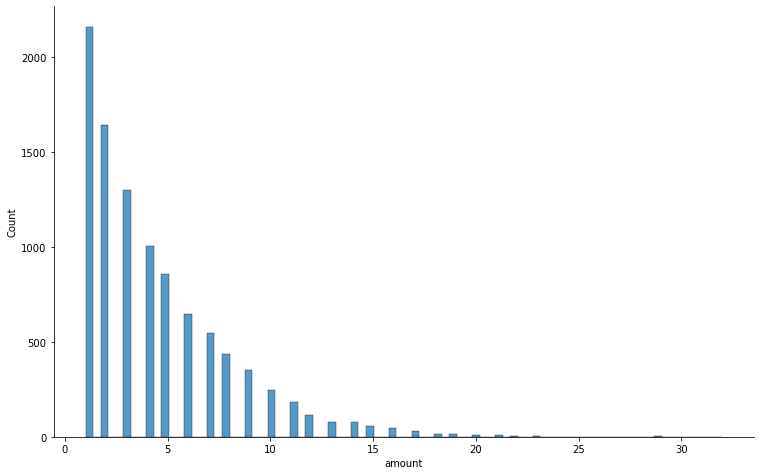

In [5]:
cnt = sns.displot(data = groc['amount'])
cnt.fig.set_size_inches(12,7)

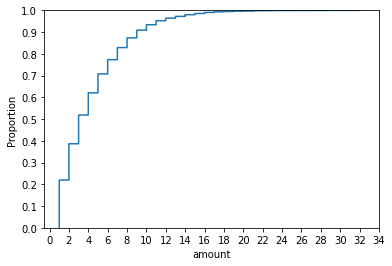

In [6]:
sns.ecdfplot(data=groc['amount'])
plt.yticks(np.arange(0.0,1.1,0.1))
plt.xticks(range(0,35,2))
plt.show()

what we can see from the two above graphs is that over 90 percent of all basket sizes fall beneath size 10. This type of information shows the type of customer that is purchashing from the store, majority of purchases are small batches and so they are not big shoppers.

### Most bought items

The approach here was to make a clean list of lists representing the purchases since the dataframe was clumsy to work with. Then a Counter objetc was used to create a tally of how many times each item was bought, creating a dataframe with this information and then plotting in a horizontal bar chart showing the 30 most bought items.
The clean list of lists will be used later as well.

In [7]:
purchases = groc.iloc[:,1:33].values.tolist()

In [8]:
clean_purchases = []
for entry in purchases:
    new = [x for x in entry if str(x) != 'nan']
    clean_purchases.append(new)

<AxesSubplot:xlabel='amount', ylabel='item'>

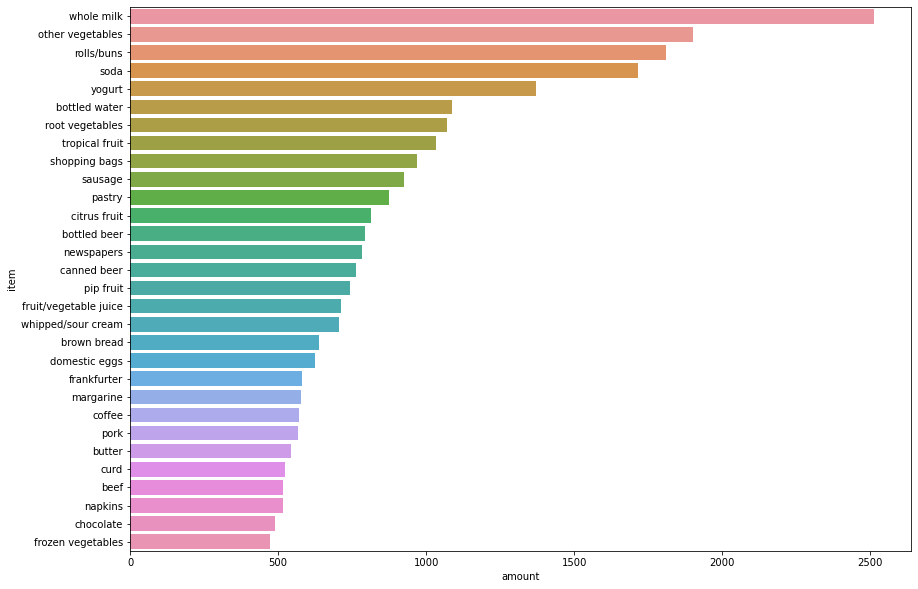

In [9]:
countset = {}
counting = Counter()
for i,result in enumerate(clean_purchases):
    counting.update(result)
countset[0]=(counting)
df = pd.DataFrame.from_dict(countset,orient='index').stack().reset_index()
countset
df.drop(['level_0'],axis=1,inplace = True)
df.rename(columns = {list(df)[0]: 'item'}, inplace = True)
df.rename(columns = {list(df)[1]: 'amount'}, inplace = True)
df.sort_values(by=['amount'],inplace=True,ascending=False)

plt.rcParams['figure.figsize']=(14,10)
sns.barplot(data = df[:30],x="amount",y="item")

### Purchases heatmap

Here we use the clean list of lists again and create a distinct list of all unique items bought. This list of unique items is iterated over to create tuples counting how many times it has been in the same basket as another item. eg ('eggs','cream',6). These tuples are then used to create a dataframe and pivoted into a heatmap which is then plotted using seaborn.

In [10]:
distinct = {x for l in clean_purchases for x in l}


In [11]:
def list_of_tuple(item):
    final = []
    for element in distinct:
        counter = 0
        if(element!=item):
            temp = [item,element]
            for purchase in clean_purchases:
                if ((item in purchase) and (element in purchase)):
                    counter+=1
            temp.append(counter)
            final.append(tuple(temp))
    return final

In [12]:
tier_list = []
for item in distinct:
    tier_list.append(list_of_tuple(item))
    
        

In [13]:
flat_list = [item for sublist in tier_list for item in sublist]

In [14]:
pairs = pd.DataFrame(flat_list,columns=['item 1','item 2','amount'])

In [15]:
pairs.sort_values(by=['amount'],inplace=True,ascending=False)
pairs = pairs.pivot(index='item 1',columns='item 2').fillna(0)

Below we have a heatmap showing a heatmap of the first 60 items (reduced in size for readability)

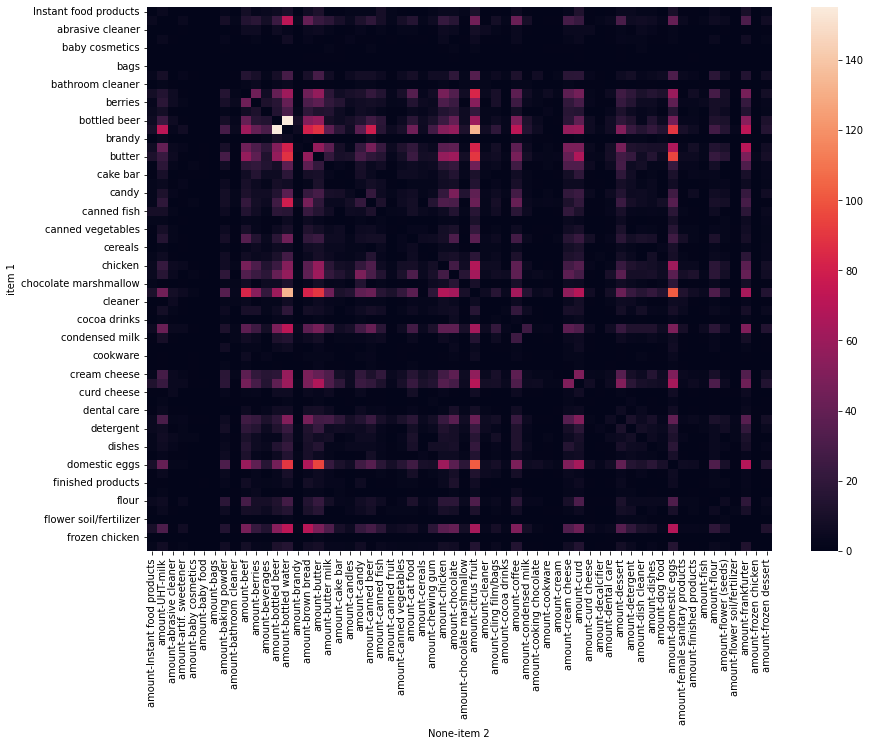

In [16]:
ax = sns.heatmap(pairs.iloc[:60,:60])

### 3. Preprocess

The data is preprocessed by createing essentially a one hot encoding for each purchase whether or not an item was in the purchase. A dictionary is created containing each a key for each item that can be bought. The value for this key is a list of 0 or 1 of len(num(transactions)) which represent whther or not the item was in the transaction. This dictionary is then converted into a datframe to be fed into the algorithm.

In [17]:
big = {}
for item in distinct:
    big[item] = []
for row in groc.iloc[:,1:33].itertuples():
    for items in distinct:
        if(items in row):
            big[items].append(1)
        else:
            big[items].append(0)


In [18]:
encoded = pd.DataFrame(big)
encoded

,soap,waffles,kitchen utensil,canned vegetables,mustard,decalcifier,syrup,candy,artif. sweetener,white wine,...,packaged fruit/vegetables,sugar,instant coffee,shopping bags,female sanitary products,frankfurter,chicken,flower soil/fertilizer,fruit/vegetable juice,specialty bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
encoded = encoded[(encoded>0).sum(axis=1) >=2] #remove all purchases with only one item
encoded

,soap,waffles,kitchen utensil,canned vegetables,mustard,decalcifier,syrup,candy,artif. sweetener,white wine,...,packaged fruit/vegetables,sugar,instant coffee,shopping bags,female sanitary products,frankfurter,chicken,flower soil/fertilizer,fruit/vegetable juice,specialty bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Rule association

The min support value chosen here is 0.05, 5%. This gives good results without having to stoop so low on the support that the resulting impact would not make much difference to support.

In [20]:
itemset = apriori(encoded,min_support=0.05,
                  use_colnames=True).sort_values('support',ascending=False).reset_index(drop=True)
itemset['length'] = itemset['itemsets'].apply(lambda x: len(x))
itemset

,support,itemsets,length
0,0.311621,(whole milk),1
1,0.239838,(other vegetables),1
2,0.221470,(rolls/buns),1
3,0.203101,(soda),1
4,0.173528,(yogurt),1
5,0.136399,(root vegetables),1
6,0.132882,(bottled water),1
7,0.131449,(tropical fruit),1
8,0.119984,(shopping bags),1
9,0.117249,(sausage),1


In [21]:
rules = association_rules(itemset,metric = 'lift',min_threshold=1).sort_values('lift',ascending=False).reset_index(drop=True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(root vegetables),(other vegetables),0.136399,0.239838,0.060709,0.445081,1.855754,0.027995,1.369861
1,(other vegetables),(root vegetables),0.239838,0.136399,0.060709,0.253123,1.855754,0.027995,1.156283
2,(root vegetables),(whole milk),0.136399,0.311621,0.062663,0.459408,1.474254,0.020158,1.273380
3,(whole milk),(root vegetables),0.311621,0.136399,0.062663,0.201087,1.474254,0.020158,1.080970
4,(other vegetables),(yogurt),0.239838,0.173528,0.055628,0.231939,1.336610,0.014009,1.076050
5,(yogurt),(other vegetables),0.173528,0.239838,0.055628,0.320571,1.336610,0.014009,1.118823
6,(yogurt),(whole milk),0.173528,0.311621,0.071782,0.413664,1.327459,0.017707,1.174035
7,(whole milk),(yogurt),0.311621,0.173528,0.071782,0.230351,1.327459,0.017707,1.073830
8,(whole milk),(tropical fruit),0.311621,0.131449,0.054195,0.173913,1.323049,0.013233,1.051404
9,(tropical fruit),(whole milk),0.131449,0.311621,0.054195,0.412289,1.323049,0.013233,1.171290


In the table above we only show rules with a lift of greater than one and as such only show positive rules.

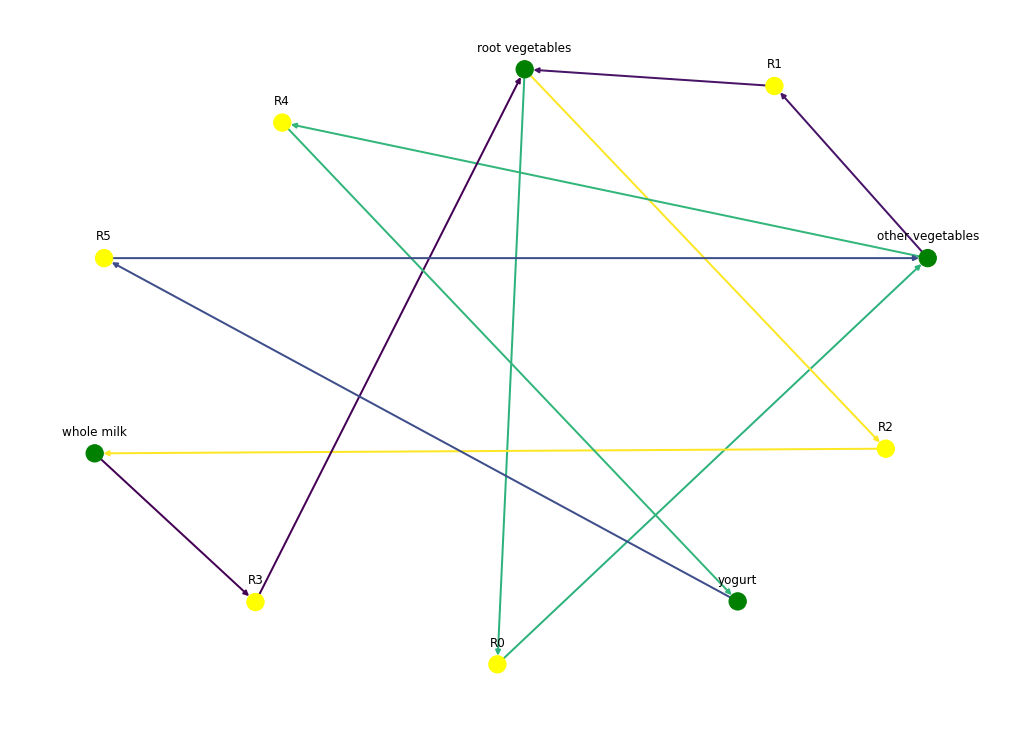

In [22]:
draw_graph(rules,6)

an approach was found using networkx to visualise the connections between elements and the rules conencting them.
eg Whole milk should be placed with root vegetables as they are linked and provide strong lift. an apporoach like this shows that items with many connections should be placed somewhere easily accessible as most people will add it to their basket should they have a connection already in their basket.

Below is a larger graph

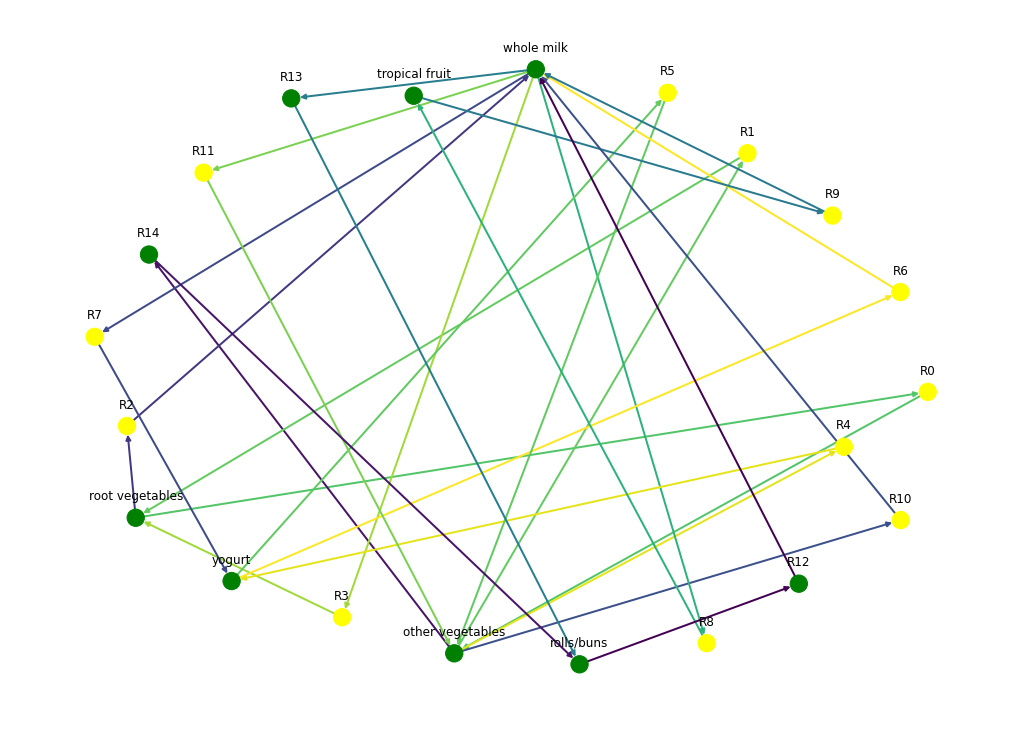

In [23]:
draw_graph(rules,15)

Here we see whole milk is highly connected and is a staple item that is bought with many other things. This should be easily accessible since it is a common stop for people when searching through the aisles.